In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Sun Dec 16 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.1
scipy 1.1.0
sklearn 0.20.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 3.10.0-862.3.2.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '75b.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
eeg_signals = np.transpose(data.values)

Opening raw data file /home/kovarm23/thesis_project/data/processed/75b.fif...
This filename (/home/kovarm23/thesis_project/data/processed/75b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 35665 =      0.000 ...   142.660 secs
Ready.


<ipython-input-24-bc3d97dc497a>:25: RuntimeWarning: This filename (/home/kovarm23/thesis_project/data/processed/75b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '75b.fif'))


In [25]:
from lib.nolitsa.nolitsa import d2, surrogates, utils
from lib.nolds.nolds.measures import corr_dim
import matplotlib.pyplot as plt

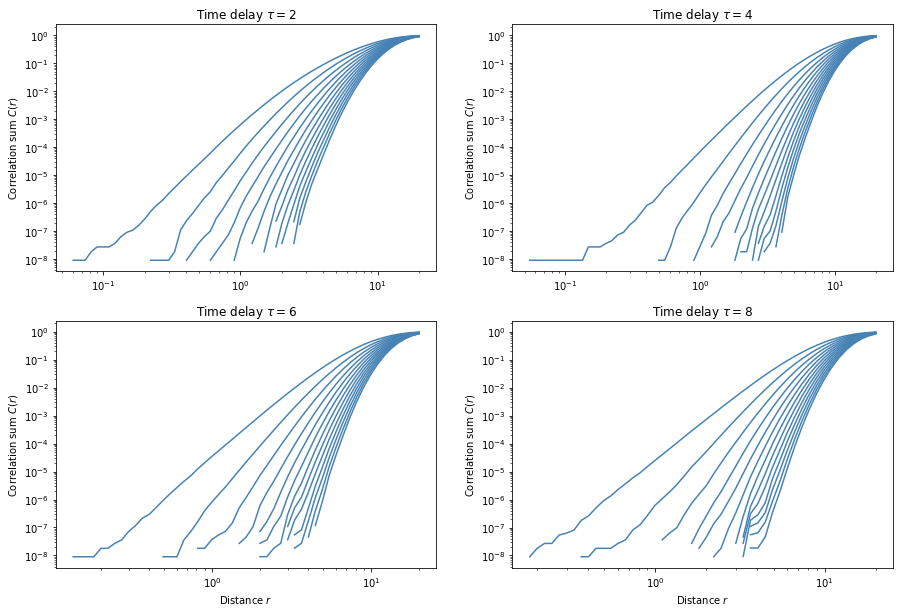

In [30]:
chan_num=0
chan_data = eeg_signals[chan_num][:15000]
plt.figure(1, figsize=(15,10))
for i, tau in enumerate(np.arange(2, 8+1, 2)):
    plt.subplot(2, 2, i+1)
    plt.title(rf'Time delay $\tau={tau}$')
    dim = np.arange(5, 30+1, 2)
    # yy = [utils.reconstruct(chan_data, d, tau) for d in dim]
    rcs = d2.c2_embed(chan_data, tau=tau, dim=dim, window=50,
                      metric='chebyshev', r=utils.gprange(0.001, 20, 100))
    if i+1 > 2:
        plt.xlabel(r'Distance $r$')
    plt.ylabel(r'Correlation sum $C(r)$')
    for r, c in rcs:
        plt.loglog(r, c, color='#4682B4')
        p = np.polyfit(np.log(r), np.log(c), 1) 
plt.show()

/home/kovarm23/thesis_project/src/lib/nolitsa/nolitsa/d2.py:180: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  d[i] = np.linalg.lstsq(A, q)[0][0]


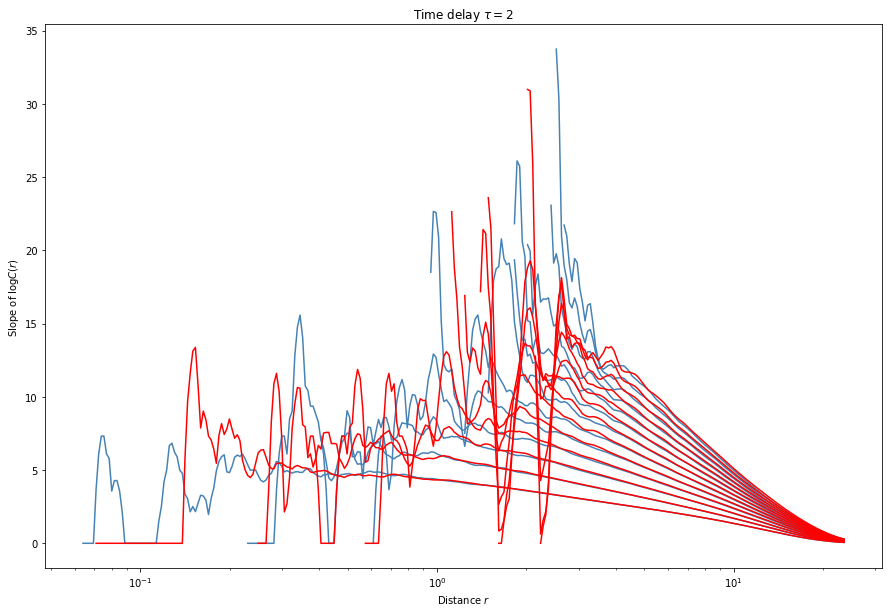

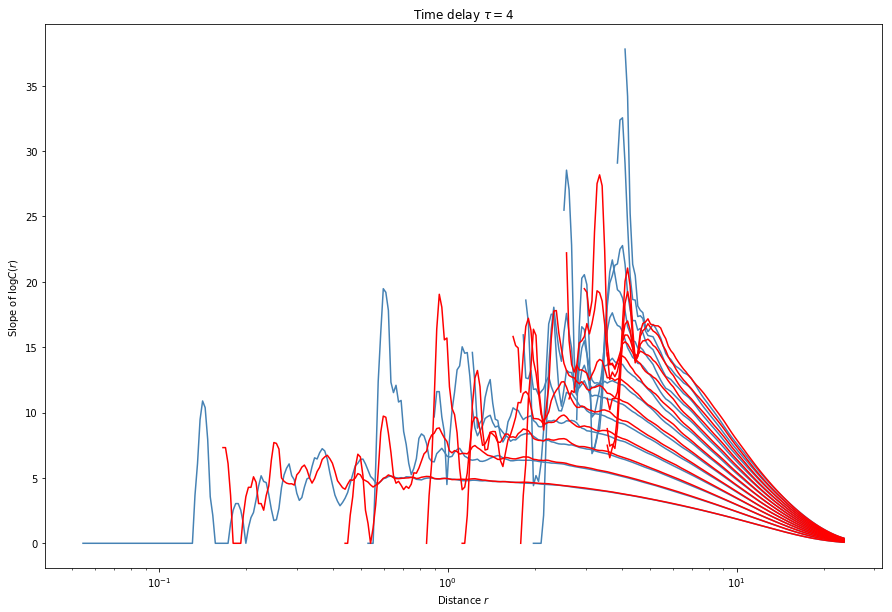

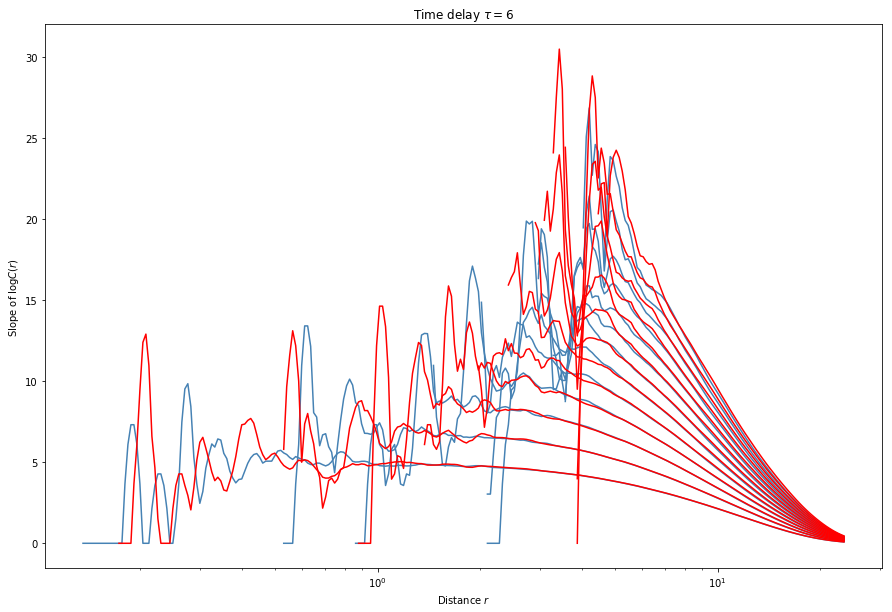

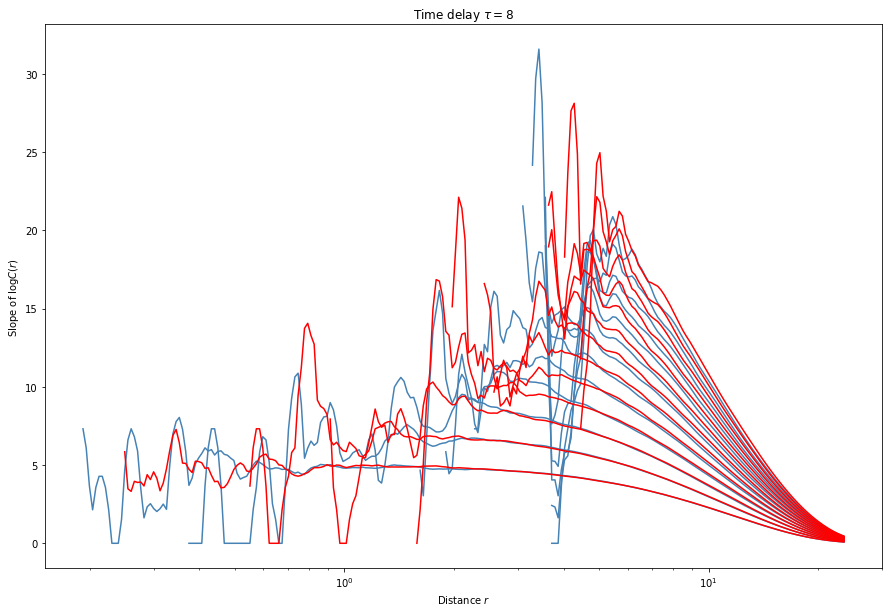

In [49]:
chan_num=0
chan_data = eeg_signals[chan_num][:15000]
for i, tau in enumerate(np.arange(2, 8+1, 2)):
    plt.figure(figsize=(15,10))
    # plt.suptitle(rf'Time delay $\tau={tau}$')
    plt.title(rf'Time delay $\tau={tau}$')
    dim = np.arange(5, 30+1, 2)
    rcs = d2.c2_embed(chan_data, tau=tau, dim=dim, window=50,
                      metric='chebyshev', r=utils.gprange(0.001, 25, 500))
    # plt.subplot(1, 2, 1)
    # plt.xlabel(r'Distance $r$')
    # plt.ylabel(r'Correlation sum $C(r)$')
    # for r, c in rcs:
    #     plt.loglog(r, c, color='#4682B4')
    #     p = np.polyfit(np.log(r), np.log(c), 1) 
        
    # plt.subplot(1, 2, 2)
    plt.xlabel(r'Distance $r$')
    plt.ylabel(r'Slope of $\log C(r)$')
    for r, c in rcs:
        plt.semilogx(r[3:-3], d2.d2(r, c), color='#4682B4')
    # Plot surrogate too
    surr_data, i, e = surrogates.iaaft(chan_data)
    rcs = d2.c2_embed(surr_data, tau=tau, dim=dim, window=50, metric='chebyshev', r=utils.gprange(0.001, 25, 500))
    for r, c in rcs:
        plt.semilogx(r[3:-3], d2.d2(r, c), color='red')
    plt.show()

In [ ]:
chan_data = eeg_signals[chan_num][:15000]
dim = np.arange(5, 30+1, 2)
for i, tau in enumerate(np.arange(2, 8+1, 2)):
    plt.figure(figsize=(15,5))
    plt.suptitle(rf'Time delay $\tau={tau}$')
    plt.subplot(121)
    # plt.title('Original')
    plt.xlabel(r'Distance $r$')
    plt.ylabel(r'Slope of $\log C(r)$')
    
    rcs = d2.c2_embed(chan_data, tau=tau, dim=dim, window=50,
                      metric='chebyshev', r=utils.gprange(0.0001, 20, 100))
    for r, c in rcs:
        plt.semilogx(r[3:-3], d2.d2(r, c), color='#4682B4')
        
    plt.subplot(122)
    # plt.title('Surrogate')
    plt.xlabel(r'Distance $r$')
    
    surr_data, i, e = surrogates.iaaft(chan_data)
    # Replot it to see difference
    for r, c in rcs:
        plt.semilogx(r[3:-3], d2.d2(r, c), color='#4682B4')
        
    rcs = d2.c2_embed(surr_data, tau=tau, dim=dim, window=50, metric='chebyshev', r=utils.gprange(0.0001, 25, 100))
# 
    for r, c in rcs:
        plt.semilogx(r[3:-3], d2.d2(r, c), color='red')
    plt.plot()

CHANNEL 0


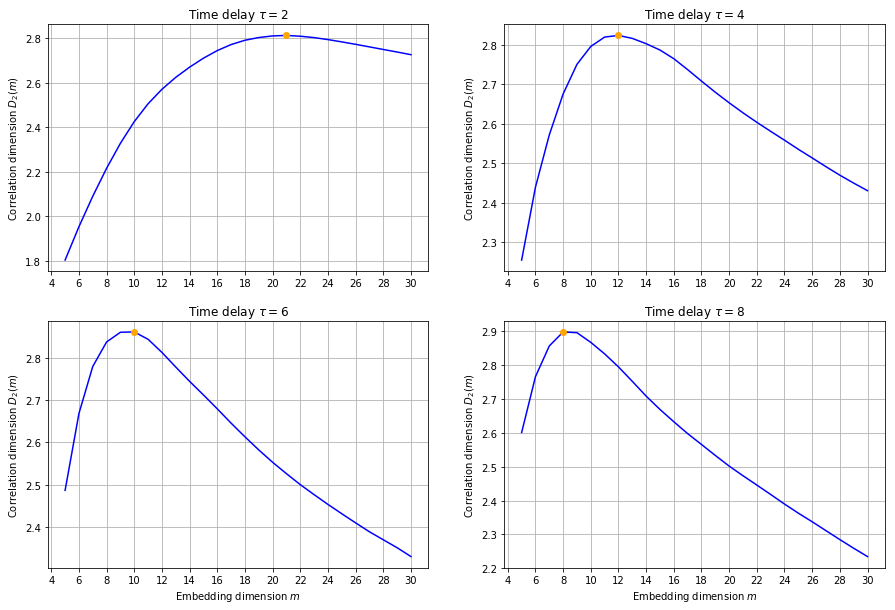

CHANNEL 1


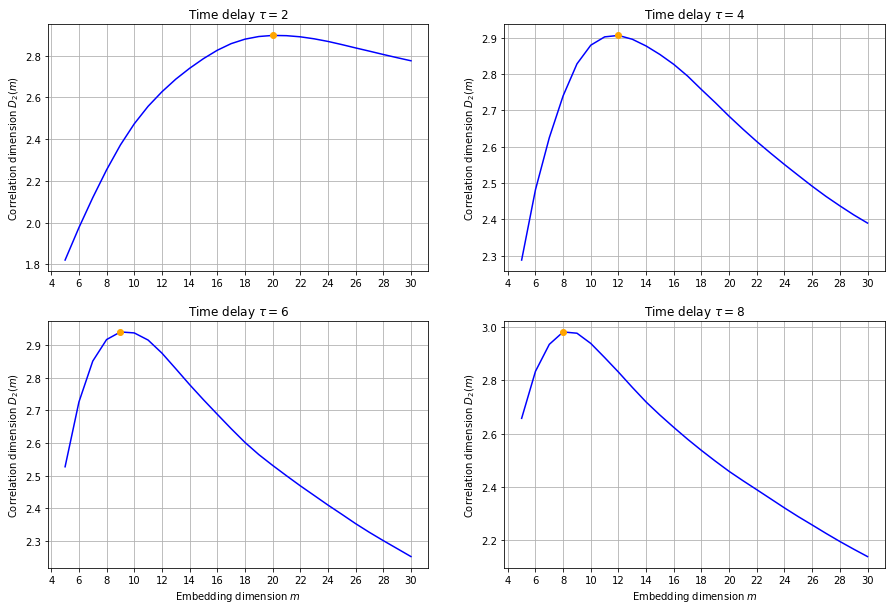

CHANNEL 2


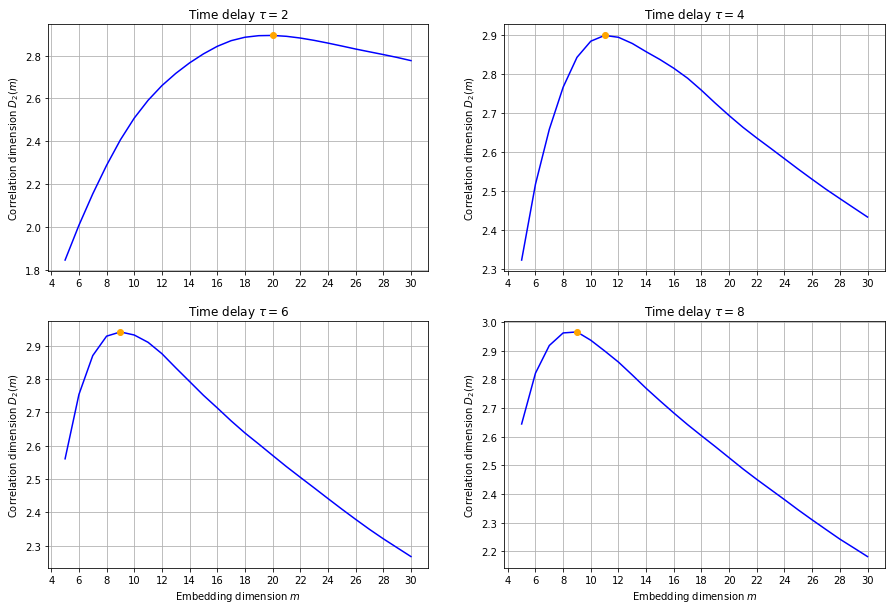

CHANNEL 3


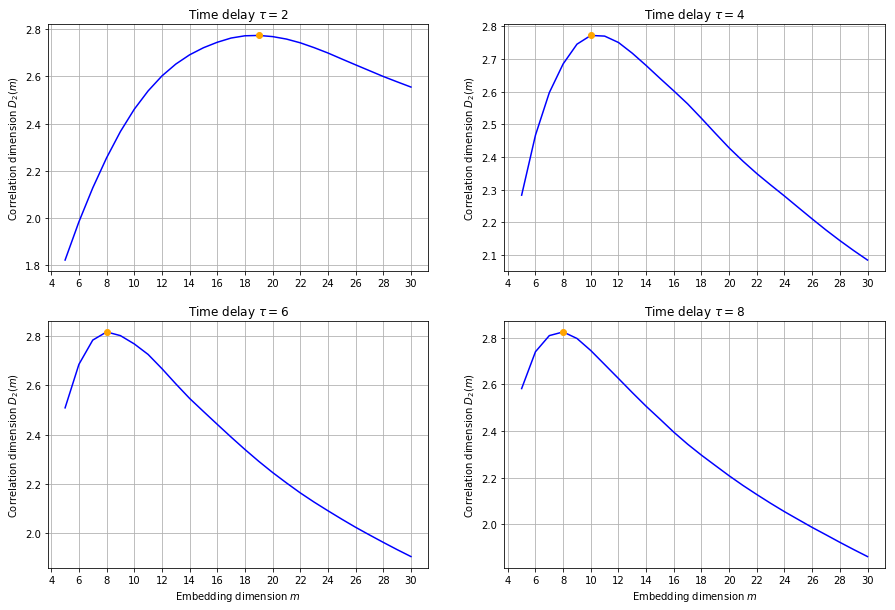

CHANNEL 4


Process ForkPoolWorker-2437:
Process ForkPoolWorker-2439:
Process ForkPoolWorker-2435:
Process ForkPoolWorker-2433:


KeyboardInterrupt: 

Process ForkPoolWorker-2432:
Process ForkPoolWorker-2434:
Process ForkPoolWorker-2428:
Process ForkPoolWorker-2436:
Traceback (most recent call last):
Process ForkPoolWorker-2438:
Process ForkPoolWorker-2429:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-2431:
Process ForkPoolWorker-2430:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kovarm23/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kovarm23/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/kovarm23/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()

  File "/home/kovarm23/miniconda3/envs/thesis/lib/python3.6/site-packages/scipy/spatial/distance.py", line 2660, in cdist
    cdist_fn(XA, XB, dm, **kwargs)
  File "/home/kovarm23/thesis_project/src/lib/nolitsa/nolitsa/utils.py", line 188, in neighbors
    dist, index = tree.query(x, k=k, p=p)
  File "/home/kovarm23/thesis_project/src/lib/nolitsa/nolitsa/utils.py", line 188, in neighbors
    dist, index = tree.query(x, k=k, p=p)
  File "/home/kovarm23/miniconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 185, in reshape
    def reshape(a, newshape, order='C'):
  File "/home/kovarm23/miniconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 878, in sort
    a.sort(axis=axis, kind=kind, order=order)
  File "/home/kovarm23/miniconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 185, in reshape
    def reshape(a, newshape, order='C'):
  File "ckdtree.pyx", line 841, in scipy.spatial.ckdtree.cKDTree.query
  

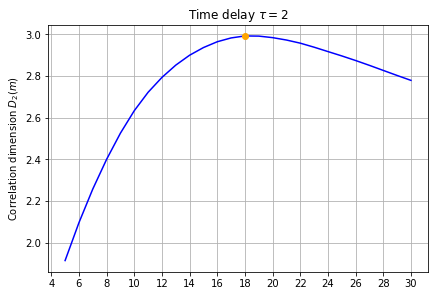

Process ForkPoolWorker-2449:
Process ForkPoolWorker-2443:
Process ForkPoolWorker-2441:
Process ForkPoolWorker-2445:
Process ForkPoolWorker-2448:
Process ForkPoolWorker-2442:
Process ForkPoolWorker-2446:
Process ForkPoolWorker-2447:
Process ForkPoolWorker-2451:
Process ForkPoolWorker-2440:
Process ForkPoolWorker-2444:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kovarm23/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/kovarm23/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/kovarm23/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstr

KeyboardInterrupt
KeyboardInterrupt
  File "/home/kovarm23/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/kovarm23/miniconda3/envs/thesis/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/kovarm23/miniconda3/envs/thesis/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


In [47]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

chan_num=0
maxdim=30
maxtau=8
chan_data = eeg_signals[chan_num][:15000]
dim = np.arange(5, maxdim+1)
for chan_num, chan_data in enumerate(eeg_signals):
    print(f'CHANNEL {chan_num}')
    plt.figure(figsize=(15,10))
    for i, tau in enumerate(np.arange(2, maxtau+1, 2)):
        rcs = d2.c2_embed(chan_data, tau=tau, dim=dim, window=50, metric='chebyshev', r=100)

        ax = plt.subplot(2, 2, i+1)
        plt.title(rf'Time delay $\tau = {tau}$')
        if i+1 > 2:
            plt.xlabel(r'Embedding dimension $m$')
        plt.ylabel(r'Correlation dimension $D_2(m)$')

        slopes = []
        for r, c in rcs:
            slopes.append(np.polyfit(np.log(r), np.log(c), 1)[0])
        # slopes = smooth(slopes, 2)
        # diffs = np.diff(slopes)
        # sums = np.asarray([np.abs(max(diffs[i-2:i+3]) - min(diffs[i-2:i+3])) for i in range(2,len(diffs)-3)])
        # i = np.argmin(sums)
        i = np.argmax(slopes)
        # plt.plot(dim, slopes, 'b-', dim[:-1], diffs, 'r-', dim[i], slopes[i], 'go')
        plt.plot(dim, slopes, 'b-')
        ax.locator_params(axis='x', nbins=maxdim/2)
        plt.plot(dim[i], slopes[i], 'o', color='orange')
        plt.grid()
    plt.show()